# LSTM in Numpy


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from module import Module

In [2]:
# Random seed
np.random.seed(420)

In [3]:
# Sigmoid helper function
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

# Derivative sigmoid helper function
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [4]:
# Open the training data and save some important variables. If you want to train on your own text, just change the .txt file in the data variable.
#data = open('shakespeare.txt', 'r').read()
data = open('nescio.txt', 'r').read()
chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

In [5]:
print(f'Data set is length {data_size}')
print(f'Vocab set is length {vocab_size}')

Data set is length 201884
Vocab set is length 88


In [6]:
# Simple character embedding
char_to_idx = {char:i for i, char in enumerate(chars)}
idx_to_char = {i:char for i, char in enumerate(chars)}

In [7]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1
epochs = 10

In [28]:
class LSTM(Module):
    
    def __init__(self, seq_length, hidden_sz, vocab_sz):
        self.weight_params = ['Whf', 'Wxf', 'Whi', 'Wxi', 'Whc', 'Wxc'
                             , 'Who', 'Wxo', 'Why', 'Bf', 'Bi', 'Bc'
                             , 'Bo', 'By']    
        self.hidden_params = ['hs', 'ct', 'ho', 'hc', 'hi', 'hf']
        
        super().__init__(seq_length, hidden_sz, vocab_sz)

    def forward(self, xs, targets):
        """
        Forward pass LSTM
        """
        
        y_preds = {}
        
        self.loss = 0
        
        for i in range(len(xs)):
            # Vectorize the input
            x = xs[i]
            x_vec = np.zeros((self.vocab_sz, 1)) 
            x_vec[x] = 1
            
            
            # Calculate new hidden and cell state
            self.hidden['hf'][i] = np.dot(self.params['Whf']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxf']['weight'], x_vec) \
                                   + self.params['Bf']['bias']
            
            self.hidden['hi'][i] = np.dot(self.params['Whi']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxi']['weight'], x_vec) \
                                   + self.params['Bi']['bias']
            
            self.hidden['hc'][i] = np.dot(self.params['Whc']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxc']['weight'], x_vec) \
                                   + self.params['Bc']['bias']
            
            self.hidden['ho'][i] = np.dot(self.params['Who']['weight'], self.hidden['hs'][i - 1]) \
                                   + np.dot(self.params['Wxo']['weight'], x_vec) \
                                   + self.params['Bo']['bias']
            
            
            f_t = sigmoid(self.hidden['hf'][i])
            i_t = sigmoid(self.hidden['hi'][i])
            cwave_t = np.tanh(self.hidden['hc'][i])
            o_t = sigmoid(self.hidden['ho'][i])
            
            self.hidden['ct'][i] = f_t * self.hidden['ct'][i - 1] + i_t * cwave_t
            self.hidden['hs'][i] = o_t * np.tanh(self.hidden['ct'][i])
            
            # Predict y
            y_preds[i] = np.dot(self.params['Why']['weight'], self.hidden['hs'][i]) \
                         + self.params['By']['bias']
            
            self.sm_ps[i] = np.exp(y_preds[i]) / np.sum(np.exp(y_preds[i])) # Softmax probability
            self.loss += -np.log(self.sm_ps[i][targets[i], 0]) # Negative loss likelyhood
            
        self.hidden['ct'][-1] = self.hidden['ct'][len(xs) - 1]
        self.hidden['hs'][-1] = self.hidden['hs'][len(xs) - 1]
        
    def backward(self, xs, targets):
        """
        Backward pass for LSTM
        """
        
        # Initialize gradients
        self.gradient_params= self.init_grads()
        
        # Start with an empty next layer for the cell state and hidden state
        dhnext = np.zeros_like(self.hidden['hs'][0])
        dcnext = np.zeros_like(self.hidden['ct'][0])
        
        # Loop over inputs and calculate gradients
        for i in reversed(range(len(xs))):
            # One hot encoding
            x = xs[i]
            x_vec = np.zeros((vocab_size, 1))
            x_vec[x] = 1
            
            dy = np.copy(self.sm_ps[i])
            dy[targets[i]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            
            self.params['By']['grad'] += dy
            self.params['Why']['grad'] += np.dot(dy, self.hidden['hs'][i].T)
            # h branches to ouput, and next layer. Therefore, we need the gradient of next layer is added
            dh = np.dot(self.params['Why']['weight'].T, dy) + dhnext 
            
            # Calculations for o
            do = dh * np.tanh(self.hidden['ct'][i]) # Weet dit niet zeker
            do = dsigmoid(self.hidden['ho'][i]) * do
            
            self.params['Wxo']['grad'] += np.dot(do, x_vec.T)
            self.params['Who']['grad'] += np.dot(do, self.hidden['hs'][i-1].T)
            self.params['Bo']['grad'] += do
            
            # Calculations for dc
            dc= dh * sigmoid(self.hidden['ho'][i]) 
            dc = (1-np.square(np.tanh(self.hidden['ct'][i]))) * dc #Weet dit ook niet zeker
            dc = dc + dcnext
            
            # Calculation dcwave
            dcwave_t = sigmoid(self.hidden['hi'][i]) * dc
            # C branches to next layer, therefore we need the gradient of that layer added.
            dcwave_t = dcwave_t * (1-np.square(np.tanh(self.hidden['hc'][i])))
            
            self.params['Wxc']['grad'] += np.dot(dcwave_t, x_vec.T)
            self.params['Whc']['grad'] += np.dot(dcwave_t, self.hidden['hs'][i-1].T)
            self.params['Bc']['grad'] += dcwave_t
            
            # Calculating di
            di = sigmoid(self.hidden['hc'][i]) * dc
            di = di * dsigmoid(self.hidden['hi'][i])
            
            self.params['Wxi']['grad'] += np.dot(di, x_vec.T)
            self.params['Whi']['grad'] += np.dot(di, self.hidden['hs'][i-1].T)
            self.params['Bi']['grad'] += di
            
            #Calculating df
            df = self.hidden['ct'][i-1] * dc
            df = dsigmoid(self.hidden['hf'][i]) * df
            
            self.params['Wxf']['grad'] += np.dot(df, x_vec.T)
            self.params['Whf']['grad'] += np.dot(df, self.hidden['hs'][i-1].T)
            self.params['Bf']['grad'] += df
            
        # Clip to prevent exploding gradients
        for dparam in self.params.keys():
            np.clip(self.params[dparam]['grad'], -5, 5, out=self.params[dparam]['grad'])
        
    def predict(self):
        pass

In [29]:
model = LSTM(seq_length, hidden_size, vocab_size)

In [30]:
model.params

{'Whf': {'size': (100, 100),
  'weight': array([[ 0.00561948,  0.00051559, -0.01120348, ..., -0.01707183,
           0.00611958,  0.00481873],
         [-0.00011756,  0.00643255, -0.00998673, ...,  0.01954665,
           0.01007174,  0.00415331],
         [ 0.01041686, -0.00441616, -0.00908383, ..., -0.00724482,
           0.00268475,  0.00757998],
         ...,
         [ 0.00930872,  0.00920596, -0.00678927, ...,  0.00610122,
          -0.0088851 , -0.00418265],
         [ 0.00316152, -0.01165784, -0.00213679, ..., -0.00551211,
          -0.02124683,  0.02451676],
         [ 0.01158105,  0.00380232, -0.00774238, ...,  0.00949632,
           0.01129446, -0.001276  ]])},
 'Wxf': {'size': (100, 88),
  'weight': array([[-0.00796916,  0.01144448,  0.00282614, ..., -0.00141578,
          -0.00212562, -0.0166846 ],
         [ 0.00371012, -0.00591864, -0.01161193, ...,  0.00416237,
          -0.00363335, -0.00056672],
         [ 0.00394772, -0.01120284,  0.00325946, ...,  0.01546167,
       

In [31]:
xs = [char_to_idx[ch] for ch in data[0:5]]
targets = [char_to_idx[ch] for ch in data[1:6]]
model.forward(xs, targets)

In [32]:
model.backward(xs, targets)

In [33]:
model.train(data, 'Adagrad', learning_rate, 2)

Epoch 1: 0 / 8075: 111.93342076431115
Epoch 1: 1000 / 8075: 75.70487276183864
Epoch 1: 2000 / 8075: 59.506348997361165
Epoch 1: 3000 / 8075: 52.28520493312015
Epoch 1: 4000 / 8075: 49.81992852442527
Epoch 1: 5000 / 8075: 48.87091989002133
Epoch 1: 6000 / 8075: 47.502880377578165
Epoch 1: 7000 / 8075: 46.446801317688504
Epoch 1: 8000 / 8075: 46.218727565531275
Epoch 2: 0 / 8075: 46.28362851907448
Epoch 2: 1000 / 8075: 45.461306976724316
Epoch 2: 2000 / 8075: 45.12655853878834
Epoch 2: 3000 / 8075: 44.63754571821134
Epoch 2: 4000 / 8075: 44.64126842591107
Epoch 2: 5000 / 8075: 44.92431440644748
Epoch 2: 6000 / 8075: 44.3987157152977
Epoch 2: 7000 / 8075: 43.804655564655185
Epoch 2: 8000 / 8075: 43.97671960504374


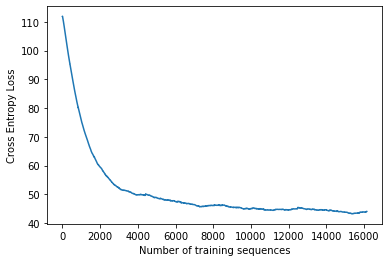

In [34]:
model.plot_losses()